In [1]:
!pip install line_profiler
!pip install stable-baselines3
!pip install shimmy
!pip install pyfolio-reloaded
!pip install wrds
!pip install swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-rpbpyg5u
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-rpbpyg5u
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 549c965f95ed3df0f9a9f95f2c27c8bf2aa437b6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-jflyhi7q/elegantrl_f7d4db301c294caea8925b2aa91b40ca
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-jflyhi7q/elegantrl_f7d4db301c294caea8925b2aa91b40ca
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit b64df20f552477f24ec50c3e5088c1e241fdc455
  Preparing metadata (setup.py) ... done


In [ ]:
import os
os.kill(os.getpid(), 9)

In [22]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from stable_baselines3.common.vec_env import DummyVecEnv
from OptimizedCode.data_scraping import run_scrape_data, scrape_data
from OptimizedCode.data_cleaning import run_clean_data, clean_data
from OptimizedCode.data_preprocessing import run_preprocess_data, process_data
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

In [23]:
history = run_scrape_data()
cleaned_data = run_clean_data(history)
preprocessed_data = run_preprocess_data(cleaned_data)

[*********************100%%**********************]  503 of 503 completed


Timer unit: 1e-09 s

Total time: 70.3421 s
File: /content/OptimizedCode/data_scraping.py
Function: scrape_data at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def scrape_data():
     7         1   86170668.0    9e+07      0.1      stock_tickers = pd.read_excel("/content/stock_tickers.xlsx")
     8         1     267199.0 267199.0      0.0      tickers = stock_tickers["Stock_Ticker"].to_list()
     9         1        7e+10    7e+10     98.0      hist = yf.download(tickers=tickers, period="max", interval='1d')
    10                                           
    11         1 1294131772.0    1e+09      1.8      dataset = pd.concat([hist.xs(key=ticker, level=1, axis=1).assign(Ticker=ticker) for ticker in tickers])
    12                                           
    13         1        786.0    786.0      0.0      return dataset



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Timer unit: 1e-09 s

Total time: 13.3014 s
File: /content/OptimizedCode/data_cleaning.py
Function: clean_data at line 25

Line #      Hits         Time  Per Hit   % Time  Line Contents
    25                                           def clean_data(hist):
    26         1  616390959.0    6e+08      4.6      hist.dropna(inplace=True)
    27                                           
    28         1  282509011.0    3e+08      2.1      ticker_counts = hist.groupby('Ticker').size()
    29         1     635063.0 635063.0      0.0      valid_tickers = ticker_counts[ticker_counts >= 8000].index
    30         1  228066063.0    2e+08      1.7      hist = hist[hist['Ticker'].isin(valid_tickers)]
    31                                           
    32         1  146735580.0    1e+08      1.1      tickers = hist['Ticker'].unique()
    33         1      48795.0  48795.0      0.0      chunk_size = (len(tickers) // mp.cpu_count()) + 1
    34         1        1e+10    1e+10     77.2      common_dat

/content/OptimizedCode/data_preprocessing.py:83: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  macd_data = df_group.apply(calculate_macd)
/content/OptimizedCode/data_preprocessing.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bb_data = df_group.apply(calculate_bollinger_bands)
/content/OptimizedCode/data_preprocessing.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns.

Timer unit: 1e-09 s

Total time: 27.2004 s
File: /content/OptimizedCode/data_preprocessing.py
Function: process_data at line 76

Line #      Hits         Time  Per Hit   % Time  Line Contents
    76                                           def process_data(cleaned_data):  
    77         1    4371867.0    4e+06      0.0      cleaned_data.reset_index(inplace=True) 
    78         1  394202645.0    4e+08      1.4      cleaned_data.sort_values(by=['Ticker', 'Date'], inplace=True)
    79         1     908853.0 908853.0      0.0      cleaned_data.set_index("Date", inplace=True)
    80                                           
    81         1     372305.0 372305.0      0.0      df_group = cleaned_data.groupby('Ticker')
    82                                           
    83         1 1450710917.0    1e+09      5.3      macd_data = df_group.apply(calculate_macd)
    84         1 1249226401.0    1e+09      4.6      bb_data = df_group.apply(calculate_bollinger_bands) 
    85         1 38736

In [24]:
test_index = preprocessed_data.index.unique()[-252:]  # Adjust this range accordingly
test_data = preprocessed_data.loc[test_index]
train_data = preprocessed_data.loc[~preprocessed_data.index.isin(test_index)]
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)
test_data['Day'] = test_data.Day - test_data.Day.min()
test_data.index = test_data['Day']
train_data.index = train_data['Day']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step


    """
    metadata = {'render.modes': ['human']}

    def __init__(self,
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):

        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list


        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        while self.day not in self.df.index.unique():
          self.day += 1

        self.data = self.df.loc[self.day,:]
        self.covs = self.data['Cov_List'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False
        self.turbulence_threshold = turbulence_threshold
        self.portfolio_value = self.initial_amount


        self.asset_memory = [self.initial_amount]
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.Date.unique()[0]]


    def step(self, actions):
        self.terminal = self.day >= self.df.Day.max()

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['Daily_Return']
            plt.plot(df.Daily_Return.cumsum(),'r')
            plt.savefig('/content/cumulative_reward.png')
            plt.close()

            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('/content/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['Daily_Return']
            if df_daily_return['Daily_Return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['Daily_Return'].mean()/ \
                       df_daily_return['Daily_Return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")

            return self.state, self.reward, self.terminal,{}

        else
            weights = self.softmax_normalization(actions)
            self.actions_memory.append(weights)
            last_day_memory = self.data


            self.day += 1
            while self.day not in self.df.index.unique():
              self.day += 1

            self.data = self.df.loc[self.day,:]
            self.covs = self.data['Cov_List'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)

            portfolio_return = sum(((self.data.Close.values / last_day_memory.Close.values)-1)*weights)

            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.Date.unique()[0])
            self.asset_memory.append(new_portfolio_value)


            self.reward = new_portfolio_value
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0

        while self.day not in self.df.index.unique():
          self.day += 1

        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['Cov_List'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount

        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.Date.unique()[0]]

        return self.state

    def render(self, mode='human'):
        return self.state

    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator

        return softmax_output


    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        df_account_value = pd.DataFrame({'Date':date_list,'Daily_Return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['Date']

        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.Ticker.values
        df_actions.index = df_date.Date

        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
stock_dimension = len(train_data.Ticker.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 274, State Space: 274


In [29]:
tech_indicator_list = ['MACD', 'Signal', 'MACD_Histogram', 'BB_Lower',
                       'BB_Upper', 'RSI', 'ADL', 'Tenkan Sen', 'Kijun Sen',
                       'Senkou Span A', 'Senkou Span B']

In [30]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": tech_indicator_list,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}

e_train_gym = StockPortfolioEnv(df = train_data, **env_kwargs)

In [32]:
from gym.envs.registration import register

register(
    id='StockPortfolioEnv-v0',
    entry_point='__main__.StockPortfolioEnv',
)

In [10]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [11]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


In [12]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=50000)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-------------------------------------
| time/                 |           |
|    fps                | 41        |
|    iterations         | 100       |
|    time_elapsed       | 11        |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -388      |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.64e+09  |
|    reward             | 1415874.4 |
|    std                | 0.998     |
|    value_loss         | 2.2e+13   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 42        |
|    iterations         | 200       |
|    time_elapsed       | 23        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -388      |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updat

In [13]:
e_trade_gym = StockPortfolioEnv(df = test_data, **env_kwargs)
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000000
end_total_asset:1122023.8577677305
Sharpe:  1.021563481113514
hit end!


In [16]:
df_daily_return.rename(columns={'Date': 'date', 'Daily_Return': 'daily_return'}, inplace=True)

In [18]:
from pyfolio import timeseries

DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats
perf_stats_all = perf_func( returns=DRL_strat,
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")
print(perf_stats_all)

Annual return          0.122024
Cumulative returns     0.122024
Annual volatility      0.119706
Sharpe ratio           1.021563
Calmar ratio           0.954143
Stability              0.542428
Max drawdown          -0.127888
Omega ratio            1.178602
Sortino ratio          1.543347
Skew                   0.183176
Kurtosis               0.461257
Tail ratio             0.941064
Daily value at risk   -0.014596
Alpha                  0.000000
Beta                   1.000000
dtype: float64


In [19]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (251, 8)
Annual return          0.121970
Cumulative returns     0.121458
Annual volatility      0.099787
Sharpe ratio           1.207835
Calmar ratio           1.352558
Stability              0.742723
Max drawdown          -0.090178
Omega ratio            1.215499
Sortino ratio          1.843499
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.078112
Daily value at risk   -0.012094
dtype: float64


In [20]:
DRL_strat

date
2023-04-28 00:00:00+00:00    0.000000
2023-05-01 00:00:00+00:00    0.000663
2023-05-02 00:00:00+00:00   -0.015301
2023-05-03 00:00:00+00:00   -0.006218
2023-05-04 00:00:00+00:00   -0.008064
                               ...   
2024-04-23 00:00:00+00:00    0.007949
2024-04-24 00:00:00+00:00    0.001055
2024-04-25 00:00:00+00:00   -0.002494
2024-04-26 00:00:00+00:00    0.000422
2024-04-29 00:00:00+00:00    0.006400
Length: 252, dtype: float64

In [45]:
temp = pd.DataFrame(DRL_strat, columns=['return'])
# temp.reset_index(inplace=True)
temp

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:75: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(column):


,return
date,
2023-04-28 00:00:00+00:00,0.000000
2023-05-01 00:00:00+00:00,0.000621
2023-05-02 00:00:00+00:00,-0.015876
2023-05-03 00:00:00+00:00,-0.005746
2023-05-04 00:00:00+00:00,-0.009164
...,...
2024-04-23 00:00:00+00:00,0.007768
2024-04-24 00:00:00+00:00,0.000564
2024-04-25 00:00:00+00:00,-0.004084


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (251, 8)



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:666: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.537%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2023-04-28
End date,2024-04-26
Total months,11
,Backtest
Annual return,11.537%
Cumulative returns,11.489%
Annual volatility,11.98%
Sharpe ratio,0.97
Calmar ratio,0.90
Stability,0.54
Max drawdown,-12.789%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.79,2023-07-26,2023-10-27,2023-12-14,102
1,6.09,2024-03-28,2024-04-18,NaT,NaN
2,4.74,2023-05-01,2023-05-31,2023-06-13,32
3,2.68,2023-12-28,2024-01-17,2024-01-30,24
4,2.29,2023-06-16,2023-06-23,2023-06-30,11


/usr/local/lib/python3.10/dist-packages/matplotlib/dates.py:462: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  d = d.astype('datetime64[us]')
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:1373: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.boxplot(


UnboundLocalError: local variable 'boxprops' referenced before assignment

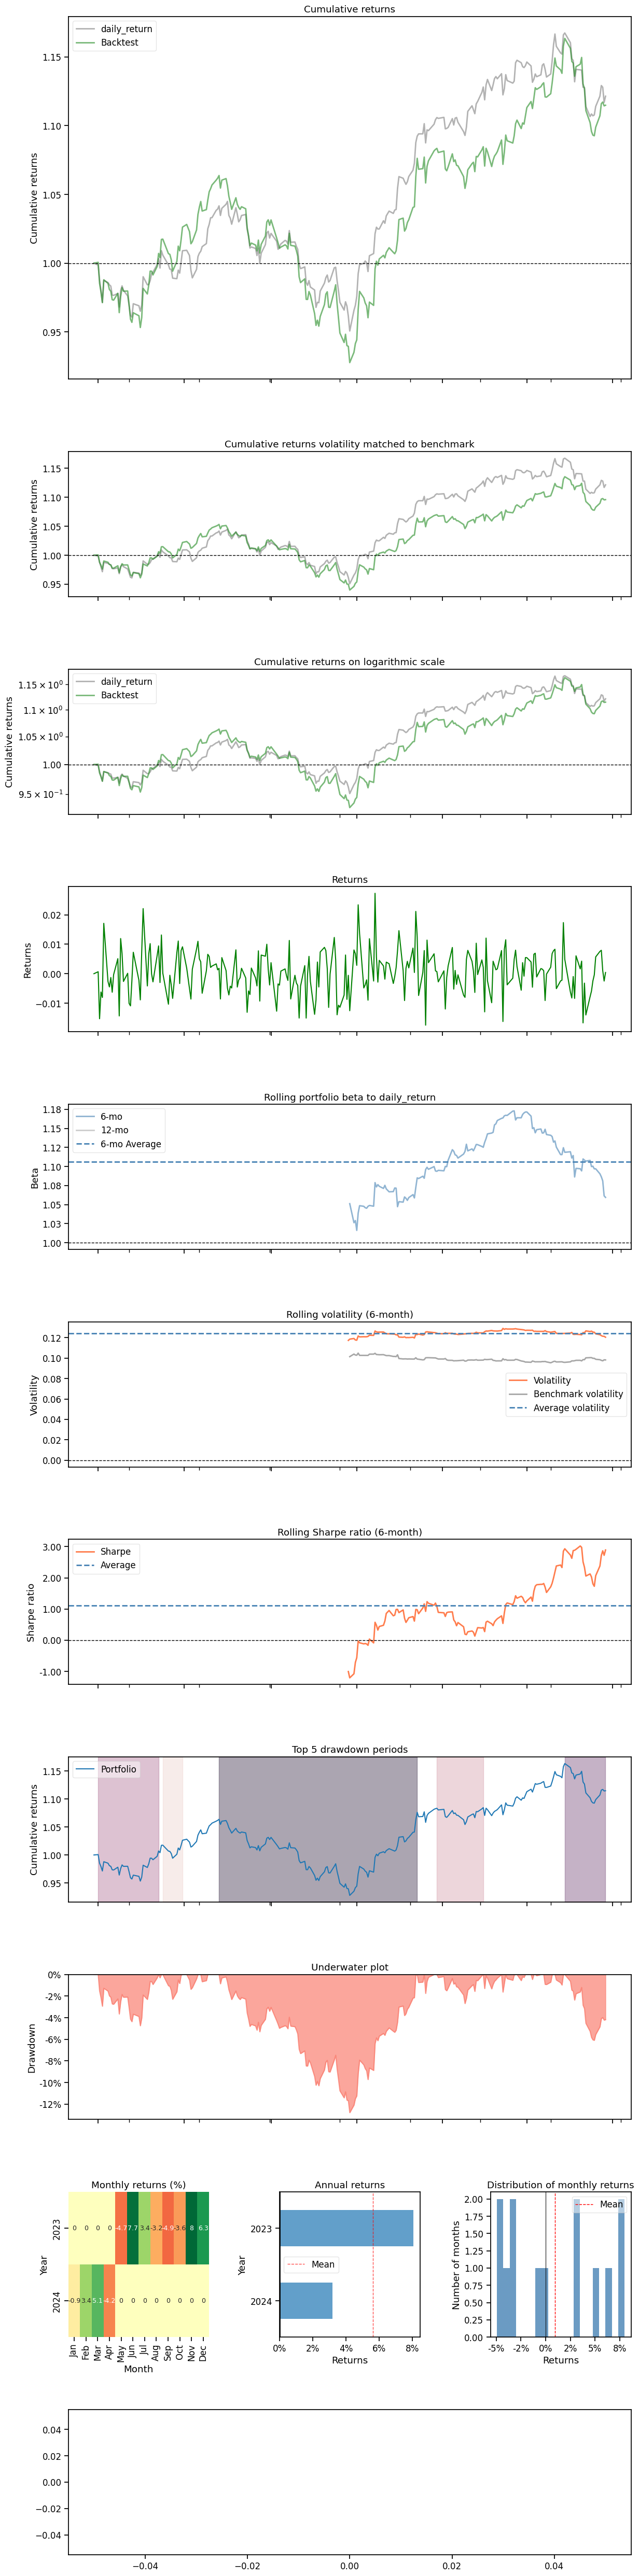

In [21]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end=df_daily_return.loc[len(df_daily_return)-1,'date'])

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [11]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device


In [12]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=80000)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


----------------------------------
| time/              |           |
|    fps             | 53        |
|    iterations      | 1         |
|    time_elapsed    | 37        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 4649701.0 |
----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 51           |
|    iterations           | 2            |
|    time_elapsed         | 79           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 6.693881e-10 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -389         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | 1.04e+15     |
|    n_updates            | 10           |
|    policy_gradient_loss | -7.34e-06   

In [14]:
e_trade_gym = StockPortfolioEnv(df = test_data, **env_kwargs)
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000000
end_total_asset:1121706.8409373893
Sharpe:  1.0299745800433684
hit end!


In [15]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [16]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:50159293.52790844
Sharpe:  0.8098146982046242
begin_total_asset:1000000
end_total_asset:50662981.20745397
Sharpe:  0.8118445026384821
begin_total_asset:1000000
end_total_asset:50662981.20745397
Sharpe:  0.8118445026384821
begin_total_asset:1000000
end_total_asset:50662981.20745397
Sharpe:  0.8118445026384821
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 14         |
|    time_elapsed    | 2095       |
|    total_timesteps | 29740      |
| train/             |            |
|    actor_loss      | -1.22e+09  |
|    critic_loss     | 5.98e+13   |
|    learning_rate   | 0.001      |
|    n_updates       | 29639      |
|    reward          | 50662980.0 |
-----------------------------------
begin_total_asset:1000000
end_total_asset:50662981.20745397
Sharpe:  0.8118445026384821
begin_total_asset:1000000
end_total_asset:50662981.20745397
Sharpe:  0.8118445026384821


In [18]:
e_trade_gym = StockPortfolioEnv(df = test_data, **env_kwargs)
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg,
                        environment = e_trade_gym)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000000
end_total_asset:1114474.967960557
Sharpe:  0.974560393350965
hit end!


In [19]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 62.58GB > 12.74GB
  warnings.warn(


In [1]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=50000)

NameError: name 'agent' is not defined